In [1282]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz

from graphviz import Source

import pydot


In [1283]:
data = pd.read_csv('combined-naca.csv')
data.head(5)
print('Shape of features: ', data.shape)
data.describe()

Shape of features:  (3652, 8)


,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.764239,0.253072,0.022089,0.016955,-0.041006,0.525791,0.561634,2310.521632
std,10.562997,0.967161,0.021333,0.021750,0.043580,0.397649,0.435943,1876.249303
min,-19.750000,-1.564400,0.003380,0.000730,-0.157400,0.003300,0.003200,6.000000
25%,-8.000000,-0.633650,0.008778,0.003210,-0.065600,0.074575,0.065575,21.000000
50%,1.000000,0.320150,0.013440,0.007820,-0.036300,0.537050,0.684850,2412.000000
75%,9.750000,1.202625,0.025755,0.020650,-0.004800,0.972025,1.000000,4412.000000
max,19.250000,1.708400,0.151610,0.149750,0.043200,1.000000,1.000000,6412.000000


In [1284]:
# data = data.sort_values(by=['Naca', 'Alpha'])


In [ ]:
# Split NACA into 4 digits:
# 1. First digit describing maximum camber as percentage of the chord.
# 2. Second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.
# 3. Last two digits describing maximum thickness of the airfoil as percent of the chord.

data['naca_1st'] = data['Naca'] // 1000
data['naca_2nd'] = data['Naca'] // 100 % 10
data['naca_3rd'] = data['Naca'] % 100

data.sample(n=10)

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca,naca_1st,naca_2nd,naca_3rd
2272,-8.25,-0.7936,0.01438,0.00936,-0.0263,1.0000,0.0117,1408,1,4,8
43,-5.00,-0.6243,0.00923,0.00349,0.0145,0.9972,0.0515,9,0,0,9
2957,-2.50,-0.0277,0.00678,0.00152,-0.0544,0.8151,0.2471,2412,2,4,12
3460,10.25,1.2156,0.01539,0.00985,-0.0189,0.1900,1.0000,2421,2,4,21
2169,-4.00,-0.4337,0.00792,0.00268,-0.0042,0.8039,0.3281,18,0,0,18
3205,-16.25,-1.2631,0.03123,0.02612,-0.0777,1.0000,0.0390,2418,2,4,18
1818,-14.50,-1.4827,0.02207,0.01679,-0.0243,1.0000,0.0379,12,0,0,12
3249,-5.00,-0.3023,0.00861,0.00293,-0.0538,0.7916,0.1993,2418,2,4,18
2177,-1.75,-0.1910,0.00729,0.00202,-0.0016,0.6628,0.4529,18,0,0,18
1521,14.75,1.7028,0.05000,0.04391,-0.0812,0.0183,0.9999,6412,6,4,12


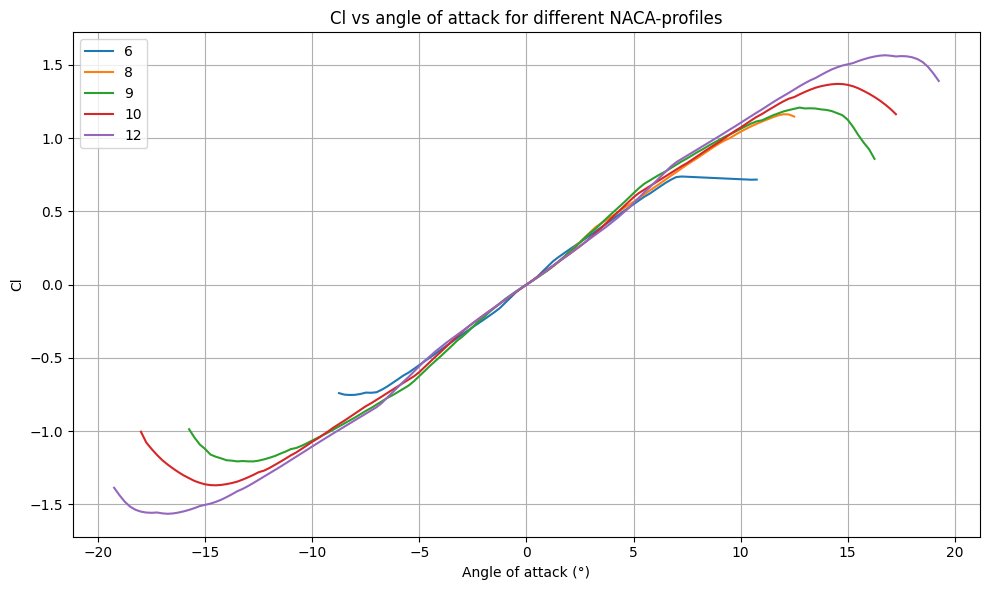

In [ ]:


groups = data.groupby('Naca')

plt.figure(figsize=(10,6))

coeff = 'Cl'
# coeff = 'Cd'

# for name, group in groups:
for name, group in islice(groups, 5):
    plt.plot(group['Alpha'], group[coeff],label=name )

plt.xlabel("Angle of attack (°)")
plt.ylabel(coeff)
plt.title(coeff + " vs angle of attack for different NACA-profiles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# Get all 
naca_unique = data.Naca.unique()

print('Unique NACAs: ', naca_unique, '\n')
print('Total size: ', naca_unique.size, '\n')

# Determine the share of data for training and testing
trainSetShare = 0.6
testSetShare = 0.38

n_train = int(trainSetShare * len(naca_unique))
n_test = int(testSetShare * len(naca_unique))
n_valid = len(naca_unique)- n_test - n_train

print('Subset sizes:')
print('- training set:', n_train)
print('- test set:', n_test)
print('- validation set:', n_valid, '\n')

# np.random.seed(3)
np.random.shuffle(naca_unique)

unique_train = naca_unique[:n_train]
unique_test = naca_unique[n_train:n_test+n_train]
unique_valid = naca_unique[n_test+n_train:]

print('- training set:', np.sort(unique_train))
print('- test set:', np.sort(unique_test))
print('- validation set:', np.sort(unique_valid))

Unique NACAs:  [   9   21 1410 2415 4415 4418 4412 4421 4424 6409 6412    6    8   10
   12   15   18 1408 1412 2408 2410 2411 2412 2414 2418 2421 2424] 

Total size:  27 

Subset sizes:
- training set: 16
- test set: 10
- validation set: 1 

- training set: [   9   10   12   15   18 1408 1410 1412 2410 2411 2414 2418 2421 2424
 4424 6409]
- test set: [   6    8   21 2408 2412 2415 4415 4418 4421 6412]
- validation set: [4412]


In [ ]:
# Split dataset into training, test and validation set

set_train = data.loc[data['Naca'].isin(unique_train)]
set_test = data.loc[data['Naca'].isin(unique_test)]
set_valid = data.loc[data['Naca'].isin(unique_valid)]

In [1289]:
features = ['Alpha', 'naca_1st', 'naca_2nd', 'naca_3rd']
label = ['Cl', 'Cd', 'Cdp', 'Cm', 'Top_Xtr', 'Bot_Xtr']

label = ['Cl', 'Cd']

In [1290]:
feature_train = set_train[features]
label_train = set_train[label]

feature_test = set_test[features]
label_test = set_test[label]

feature_valid = set_valid[features]
label_valid = set_valid[label]

feature_test

# plt.figure(figsize=(10,6))

# coeff = 'Cl'

# # for name, group in groups:
# for name, group in groups:
#     if name in unique_test:
#         plt.plot(group['Alpha'], group[coeff],label=name )

# plt.xlabel("Angle of attack (°)")
# plt.ylabel(coeff)
# plt.title(coeff + " vs angle of attack for different NACA-profiles")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

,Alpha,naca_1st,naca_2nd,naca_3rd
129,-19.75,0,0,21
130,-19.50,0,0,21
131,-19.25,0,0,21
132,-19.00,0,0,21
133,-18.75,0,0,21
...,...,...,...,...
3038,18.25,2,4,12
3039,18.50,2,4,12
3040,18.75,2,4,12
3041,19.00,2,4,12


In [1291]:
print('Training Features Shape:', feature_train.shape)
print('Training Labels Shape:', label_train.shape)
print('Testing Features Shape:', feature_test.shape)
print('Testing Labels Shape:', label_test.shape)
print('Validation Features Shape:', feature_valid.shape)
print('Validation Labels Shape:', label_valid.shape)
print(feature_test,label_test)

Training Features Shape: (2274, 4)
Training Labels Shape: (2274, 2)
Testing Features Shape: (1242, 4)
Testing Labels Shape: (1242, 2)
Validation Features Shape: (136, 4)
Validation Labels Shape: (136, 2)
      Alpha  naca_1st  naca_2nd  naca_3rd
129  -19.75         0         0        21
130  -19.50         0         0        21
131  -19.25         0         0        21
132  -19.00         0         0        21
133  -18.75         0         0        21
...     ...       ...       ...       ...
3038  18.25         2         4        12
3039  18.50         2         4        12
3040  18.75         2         4        12
3041  19.00         2         4        12
3042  19.25         2         4        12

[1242 rows x 4 columns]           Cl       Cd
129  -1.3432  0.07827
130  -1.3520  0.07412
131  -1.3588  0.07026
132  -1.3630  0.06671
133  -1.3640  0.06359
...      ...      ...
3038  1.5328  0.07268
3039  1.5214  0.07778
3040  1.5083  0.08321
3041  1.4942  0.08893
3042  1.4781  0.09506

[1

In [1292]:
rf = RandomForestRegressor(n_estimators=7, random_state=25)

rf.fit(feature_train, label_train);

In [1293]:
predictions = rf.predict(feature_test)

print(predictions.shape)
print(set_test.shape)

errors = abs(predictions -  label_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees')
predictions

(1242, 2)
(1242, 11)
Mean Absolute Error:  0.04 degrees


array([[-1.32334286,  0.08622714],
       [-1.33242857,  0.08183286],
       [-1.33545714,  0.08048714],
       ...,
       [ 1.38434286,  0.09394286],
       [ 1.37768571,  0.09657429],
       [ 1.36917143,  0.09996857]], shape=(1242, 2))

In [1294]:
# df_predict = pd.DataFrame(predictions, columns=['Cl', 'Cd'])



# df_predict = pd.concat([df_predict, set_test.drop(columns=['Cl', 'Cd'])], axis=1, join="inner")


# pd.set_option("display.max_rows", 10)
# pd.set_option("display.max_rows", None)

# groups_predict = df_predict.groupby('Naca')
# list_groups  = list(groups)
# list_predict = list(groups_predict)

# df_predict
# # # print(list_predict)
# i_naca = 0
# name = list_predict[i_naca][0]
# coeff = 'Cl'


# # print(groups_predict.size())


# #



# plt.figure(figsize=(10,6))

# plt.plot(groups.get_group(name)['Alpha'], groups.get_group(name)[coeff], label=(name))
# plt.plot(groups_predict.get_group(name)['Alpha'], groups_predict.get_group(name)[coeff], label=(name, 'predicted'))

# plt.xlabel("Angle of attack (°)")
# plt.ylabel(coeff)
# plt.title(coeff + " vs angle of attack for different NACA-profiles")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [1295]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / abs(label_test))

accuracy = 100 - np.mean(mape)

print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  68.77 %


In [1296]:
r2_Cl = r2_score(label_test['Cl'], predictions[:,0])
r2_Cd = r2_score(label_test['Cd'], predictions[:,1])

print('R-squared for predictions:')
print(f"- Cl: r2 = {r2_Cl:.3f}")
print(f"- Cd: r2 = {r2_Cd:.3f}")

R-squared for predictions:
- Cl: r2 = 0.988
- Cd: r2 = 0.810


In [1297]:
# # Pull out one tree from the forest
# #tree = rf.estimators_[5]
# # Pull out one tree from the forest
# tree = rf.estimators_[0]
# ## Export the image to a dot file

# dot_file_path = 'random_forest_tree.dot'

# export_graphviz(
#     tree,
#     out_file = dot_file_path,
#     feature_names = features,
#     rounded = True,
#     precision = 1)

# with open(dot_file_path) as f:
#     dot_graph = f.read()

# #Visualize the tree using graphviz
# graph = Source(dot_graph)
# graph.render("random_forest_tree")
# graph #Display the tree graph

863    4
864    4
865    4
866    4
867    4
      ..
994    4
995    4
996    4
997    4
998    4
Name: naca_1st, Length: 136, dtype: int64
863    4
864    4
865    4
866    4
867    4
      ..
994    4
995    4
996    4
997    4
998    4
Name: naca_2nd, Length: 136, dtype: int64
863    12
864    12
865    12
866    12
867    12
       ..
994    12
995    12
996    12
997    12
998    12
Name: naca_3rd, Length: 136, dtype: int64


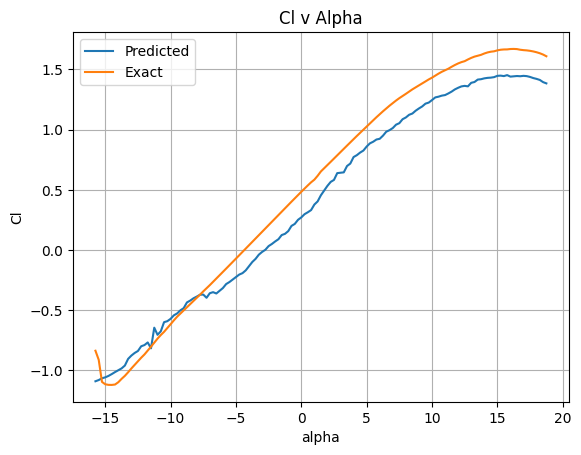

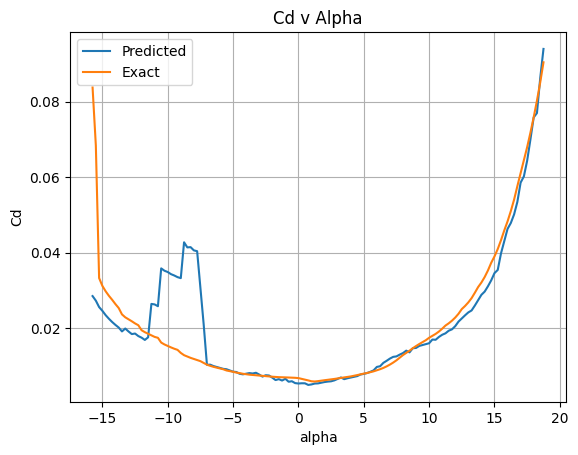

In [1298]:
prediction = rf.predict(feature_valid)
alpha = feature_valid['Alpha']

np.squeeze(prediction)

print(feature_valid['naca_1st'])
print(feature_valid['naca_2nd'])
print(feature_valid['naca_3rd'])

exact = label_valid['Cl']
plt.figure()
plt.plot(alpha,prediction[:,0])
plt.plot(alpha,exact)
plt.grid();
plt.xlabel('alpha');
plt.ylabel('Cl');
plt.title('Cl v Alpha')
plt.legend(['Predicted', 'Exact'])

exact = label_valid['Cd']
plt.figure()
plt.plot(alpha,prediction[:,1])
plt.plot(alpha,exact)
plt.grid();
plt.xlabel('alpha');
plt.ylabel('Cd');
plt.title('Cd v Alpha')
plt.legend(['Predicted', 'Exact'])


